In [1]:
import collections
import csv
import itertools
import matplotlib.pyplot as plt
import json
import os
import pathlib

import pandas as pd

CSV_FILE = pathlib.Path("/Users/shinewu/tmp/query_output_start_0401.csv")

In [29]:
import snowflake.connector as sf_conn

_SNOWFLAKE_CONTEXT = None


def snowflake_run_query(sql):
    global _SNOWFLAKE_CONTEXT
    if _SNOWFLAKE_CONTEXT is None:
        _SNOWFLAKE_CONTEXT = sf_conn.connect(
            user="xiang_wu",
            password=os.getenv("SNOWFLAKE_PASSWORD"),
            account="opensea.us-east-1",
        )

    cs = _SNOWFLAKE_CONTEXT.cursor()
    cs.execute(sql)
    return cs.fetch_pandas_all()

In [57]:
PURCHASE_START_DATE = "2022-03-01"
PURCHASE_STOP_DATE = "2022-05-31"
DOLLAR_TOP_K = 100
TIME_TOP_K = 50

PURCHASE_SEQ_SQL = f"""
    WITH 
    
    sales_by_dollar AS (
      SELECT
        winner_account_id,
        collection_id,
        event_timestamp,
        total_usd,
        RANK() OVER (
          PARTITION BY winner_account_id
          ORDER BY
            total_usd DESC
        ) AS dollar_rank
      FROM
        dbt_dwh.public.dim_transaction
      WHERE
        event_timestamp >= '{PURCHASE_START_DATE} 00:00:00'
        AND event_timestamp <= '{PURCHASE_STOP_DATE} 23:59:59'
    ),
    
    sales_by_timestamp AS (
      SELECT
        winner_account_id,
        collection_id,
        event_timestamp,
        total_usd,
        RANK() OVER (
          PARTITION BY winner_account_id
          ORDER BY
            event_timestamp DESC
        ) AS time_rank
      FROM
        sales_by_dollar
      WHERE
        dollar_rank <= {DOLLAR_TOP_K}
    )
    
    --
    
    SELECT
      winner_account_id,
      collection_id,
      event_timestamp,
      total_usd
    FROM
      sales_by_timestamp
    WHERE
      time_rank <= {TIME_TOP_K}
"""

print(PURCHASE_SEQ_SQL)


    WITH 
    
    sales_by_dollar AS (
      SELECT
        winner_account_id,
        collection_id,
        event_timestamp,
        total_usd,
        RANK() OVER (
          PARTITION BY winner_account_id
          ORDER BY
            total_usd DESC
        ) AS dollar_rank
      FROM
        dbt_dwh.public.dim_transaction
      WHERE
        event_timestamp >= '2022-03-01 00:00:00'
        AND event_timestamp <= '2022-05-31 23:59:59'
    ),
    
    sales_by_timestamp AS (
      SELECT
        winner_account_id,
        collection_id,
        event_timestamp,
        total_usd,
        RANK() OVER (
          PARTITION BY winner_account_id
          ORDER BY
            event_timestamp DESC
        ) AS time_rank
      FROM
        sales_by_dollar
      WHERE
        dollar_rank <= 100
    )
    
    --
    
    SELECT
      winner_account_id,
      collection_id,
      event_timestamp,
      total_usd
    FROM
      sales_by_timestamp
    WHERE
      time_rank <= 50



In [58]:
RUN_SQL = True
RAW_TRAINING_DF_FILE = pathlib.Path(
    f"/Users/shinewu/tmp/raw_training_df_{PURCHASE_START_DATE}_{PURCHASE_STOP_DATE}.pickle"
)

if RUN_SQL:
    RAW_TRAINING_DF = snowflake_run_query(PURCHASE_SEQ_SQL)
    RAW_TRAINING_DF.to_pickle(RAW_TRAINING_DF_FILE)
else:
    RAW_TRAINING_DF = pd.read_pickle(RAW_TRAINING_DF_FILE)

In [59]:
RAW_TRAINING_DF.head()

,WINNER_ACCOUNT_ID,COLLECTION_ID,EVENT_TIMESTAMP,TOTAL_USD
0,240593334,13776805,2022-04-23 12:51:14-07:00,413.967119
1,240593334,2960355,2022-04-22 20:53:17-07:00,1478.193758
2,240593334,2960355,2022-04-08 09:52:42-07:00,2155.556080
3,240593334,12682876,2022-04-05 20:26:41-07:00,328.156168
4,240593334,7446982,2022-04-05 06:05:17-07:00,386.935835


In [60]:
tmp = RAW_TRAINING_DF.copy()
tmp = tmp.assign(
    time_purchase=pd.Series(
        zip(tmp.EVENT_TIMESTAMP, tmp.COLLECTION_ID, tmp.TOTAL_USD)
    )
)

tmp = tmp.groupby(["WINNER_ACCOUNT_ID"])["time_purchase"].agg(list)
tmp = tmp.apply(lambda x: list(sorted(x)))
GROUPED_TRAINING_DF = tmp

GROUPED_TRAINING_DF.head()

WINNER_ACCOUNT_ID
4     [(2022-04-27 11:16:33-07:00, 13646763, 115.082...
5     [(2022-03-06 11:12:59-08:00, 934680, 181.48809...
9     [(2022-04-06 22:23:43-07:00, 1865802, 93.07451...
11    [(2022-05-09 10:25:11-07:00, 829688, 10475.778...
12    [(2022-04-04 01:29:08-07:00, 12722887, 2412.23...
Name: time_purchase, dtype: object

In [61]:
print(len(GROUPED_TRAINING_DF))
GROUPED_TRAINING_DF.iloc[1] 

886063


[(Timestamp('2022-03-06 11:12:59-0800', tz='America/Los_Angeles'),
  934680,
  181.4880999898262),
 (Timestamp('2022-03-18 18:07:51-0700', tz='America/Los_Angeles'),
  1319215,
  178.07913200903144),
 (Timestamp('2022-04-04 05:20:52-0700', tz='America/Los_Angeles'),
  12722887,
  2303.0673710590127),
 (Timestamp('2022-04-14 09:08:25-0700', tz='America/Los_Angeles'),
  12882946,
  359.1543191937883),
 (Timestamp('2022-04-14 13:05:19-0700', tz='America/Los_Angeles'),
  12882946,
  356.6315253004643),
 (Timestamp('2022-05-08 08:34:15-0700', tz='America/Los_Angeles'),
  12882946,
  178.43464706635055)]

In [80]:
def pairs_with_change(row, max_window=3):
    n = len(row)
    for i in range(n - 1):
        for j in range(1, min(n - 1 - i, max_window) + 1):
            if row[i][1] != row[i + j][1]:
                yield row[i][1], row[i + j][1]
                
def total_num_pairs(df):
    l = df.apply(lambda x: len(x) * (len(x) - 1) // 2)
    return l.sum()

In [81]:
ALL_PAIRS = list(itertools.chain(*GROUPED_TRAINING_DF.apply(pairs_with_change)))
print(total_num_pairs(GROUPED_TRAINING_DF), len(ALL_PAIRS))

59790368 6958230


In [82]:
print(ALL_PAIRS[:10])

[(934680, 1319215), (934680, 12722887), (934680, 12882946), (1319215, 12722887), (1319215, 12882946), (1319215, 12882946), (12722887, 12882946), (12722887, 12882946), (12722887, 12882946), (1865802, 2549)]


In [83]:
left_counter = collections.Counter(x[0] for x in ALL_PAIRS)
print(left_counter.most_common()[:10])

right_counter = collections.Counter(x[1] for x in ALL_PAIRS)
print(right_counter.most_common()[:10])

[(3072, 35337), (8406538, 33414), (8179453, 32604), (8699308, 32561), (14077255, 32424), (8146804, 30850), (12682876, 30548), (8268014, 29542), (8076460, 27547), (14919425, 27075)]
[(14077255, 46318), (3072, 46307), (14919425, 36615), (15130764, 31007), (8406538, 29891), (8699308, 28887), (12682876, 28498), (13557287, 28125), (13301160, 26425), (15650945, 26284)]


In [84]:
ALL_PAIR_COUNTER = collections.Counter(ALL_PAIRS)
print(ALL_PAIR_COUNTER.most_common()[:10])

[((7577462, 8018570), 4241), ((13904886, 14501940), 3775), ((14501940, 14784047), 2857), ((4371060, 2818185), 2826), ((14902164, 14953088), 2618), ((6523817, 6525063), 2543), ((8881972, 13904886), 2521), ((2818185, 4371060), 2278), ((8018570, 7577462), 2237), ((13904886, 14784047), 1985)]


In [95]:
def feature_in_select(is_collection, feature_name, feature_rename_to=None):
    if feature_rename_to is None:
        feature_rename_to = feature_name
    table_prefix = ("a" if is_collection else "b") + "."
    return f"{table_prefix}{feature_name} AS {feature_rename_to}"


def fetch_collection_features(today, collection_ids, batch=1000):
    col_features = ["ID", "DEFAULT_CHAIN_ID", "SLUG"]
    stat_features = [
        "SEVEN_DAY_AVERAGE_PRICE",
        "THIRTY_DAY_AVERAGE_PRICE",
        "SEVEN_DAY_CHANGE",
        "THIRTY_DAY_CHANGE",
        "SEVEN_DAY_SALES",
        "THIRTY_DAY_SALES",
        "SEVEN_DAY_VOLUME",
        "THIRTY_DAY_VOLUME",
        "NUM_OWNERS",
        "TOTAL_SUPPLY",
    ]
    features = ",\n".join(
        [feature_in_select(True, f) for f in col_features]
        + [feature_in_select(False, f) for f in stat_features]
        + [f"DATEDIFF(DAY, a.CREATED_DATE, '{today}'::DATE) AS DAYS_FROM_CREATION"]
    )
    all_collection_ids = ", ".join(str(i) for i in collection_ids)

    sql = f"""
        SELECT
          {features}
        FROM
          PC_FIVETRAN_DB.PUBLIC.API_COLLECTION a
          LEFT JOIN PC_FIVETRAN_DB.PUBLIC.API_COLLECTIONSTATS b
          ON a.ID = b.COLLECTION_ID
        WHERE
          a.BLACKLISTED = FALSE
          AND a.HIDDEN = FALSE
          AND a.IS_DELISTED = FALSE
          AND a.IS_LISTABLE = TRUE
          AND a.IS_NSFW = FALSE
          AND a.ID in ({all_collection_ids})
        LIMIT {batch}
    """
    return sql

In [109]:
df = snowflake_run_query(fetch_collection_features("2022-05-31", collection_ids=pair))
print(df)

        ID  DEFAULT_CHAIN_ID                         SLUG  \
0  7577462                 3               sunflower-land   
1  8018570                 3  sunflower-land-collectibles   

   SEVEN_DAY_AVERAGE_PRICE  THIRTY_DAY_AVERAGE_PRICE  SEVEN_DAY_CHANGE  \
0                 0.003703                  0.004656          0.126827   
1                 0.014779                  0.015900         -0.193836   

   THIRTY_DAY_CHANGE  SEVEN_DAY_SALES  THIRTY_DAY_SALES  SEVEN_DAY_VOLUME  \
0          -0.828713            926.0            6904.0          3.429231   
1          -0.508117           1612.0           10471.0         23.823257   

   THIRTY_DAY_VOLUME  NUM_OWNERS  TOTAL_SUPPLY  DAYS_FROM_CREATION  
0          32.147060    134482.0      143901.0                 103  
1         166.493701    150774.0         121.0                  92  


In [110]:
for pair, count in ALL_PAIR_COUNTER.most_common()[:10]:
    df = snowflake_run_query(
        fetch_collection_features("2022-05-31", collection_ids=pair)
    )
    slug_map = dict(zip(df.ID, df.SLUG))
    if len(slug_map) == 2:
        print(f"{slug_map[pair[0]]} -> {slug_map[pair[1]]}")
    else:
        pass

sunflower-land -> sunflower-land-collectibles
suncity-ape-club-1 -> bearsbulls-fight
bearsbulls-fight -> the-cornz
crypto-unicorns-land-market -> crypto-unicorns-market
raidparty -> raidpartyfighters
crypto-unicorns-market -> crypto-unicorns-land-market
sunflower-land-collectibles -> sunflower-land
suncity-ape-club-1 -> the-cornz


57784


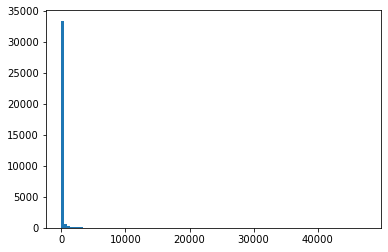

In [12]:
uniq_cs = uniq_collections(WINNER_TO_COLLECTIONS)
print(len(uniq_cs))
counts = list(uniq_cs.values())
counts.sort(reverse=True)
counts = [x for x in counts if x != 1]
_ = plt.hist(counts, bins=100)

In [13]:
uniq_cids = list(uniq_cs.keys())
batch = 10000
dfs = []
for batch_start in range(0, len(uniq_cids), batch):
    batch_stop = min(batch_start + batch, len(uniq_cids))
    batch_sql = fetch_collection_features(
        today="2022-06-02",
        collection_ids=uniq_cids[batch_start:batch_stop],
        batch=batch,
    )
    dfs.append(snowflake_run_query(batch_sql))
ALL_COLLECTION_FEATURES = pd.concat(dfs)

In [14]:
ALL_COLLECTION_FEATURES.head()

,ID,DEFAULT_CHAIN_ID,SLUG,SEVEN_DAY_AVERAGE_PRICE,THIRTY_DAY_AVERAGE_PRICE,SEVEN_DAY_CHANGE,THIRTY_DAY_CHANGE,SEVEN_DAY_SALES,THIRTY_DAY_SALES,SEVEN_DAY_VOLUME,THIRTY_DAY_VOLUME,NUM_OWNERS,TOTAL_SUPPLY,DAYS_FROM_CREATION
0,6052873,1,mip-network,25.435385,30.105000,0.078368,-0.708048,26.0,116.0,661.320,3492.180,4818.0,9575.0,128
1,6879411,1,donutshop,31.680000,26.171143,-0.783518,-0.705635,5.0,63.0,158.400,1648.782,3416.0,5432.0,117
2,2200460,1,apparitions-by-aaron-penne,0.000000,2014.071429,-1.000000,-0.430612,0.0,14.0,0.000,28197.000,729.0,1500.0,229
3,257103,1,punksvoxels,56.876400,77.475284,0.708000,-0.877412,55.0,148.0,3128.202,11466.342,1503.0,9987.0,436
4,519943,1,low-effort-punks,21.401695,32.671286,0.910663,-0.342246,118.0,140.0,2525.400,4573.980,1282.0,5146.0,399
